# Calculating the longitudinal field

(In construction. Status: developing the Bz function in here, to be ported to a module afterward)

The calculation of the longitudinal field from a Stokes V line profile is done using:

$$B_{||} = \frac{1}{g_\mathrm{eff} \lambda_{B,\mathrm{const}} \lambda_o c}\frac{\int vV(v)dv}{\int (1-I(v))dv},$$

where $I$ and $V$ are in fact $V/I_c$ and $I/I_c$, and

$$\lambda_{B,\mathrm{const}} = \frac{e}{4\pi m_e c^2} = 4.67\times 10^{-13} \mathrm{Angstrom}^{-1} \mathrm{G}^{-1}$$

Note that the `Bz` function presented here requires $\lambda_o$ to be given as a astropy unit quantity (e.g. `500*u.nm` or `5000*u.AA`), and the unit conversion is handeled by the unit package to give a result in magnetic field Gauss units. 

We assume that the LSD profile passed to the function is not an astropy unit quantity, and we assume that it is in km/s. Thus if you would like to make a `Bz` calculation on e.g. an indovidual line profile on a wavelength scale, you will have to convert to km/s first. 

In [7]:
import specpolFlow as pol
import astropy.units as u
import pandas as pd

## 1. A simple example with a single LSD profile

We start by loading a LSD profile and having a quick look at it with the built-in plotting routine.

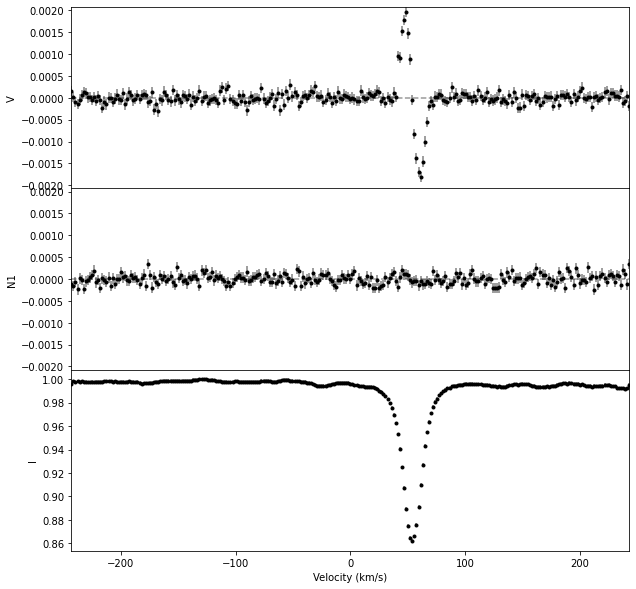

In [8]:
lsd = pol.iolsd.read_lsd('SampleData/SampleLSD.s')
fig, ax = lsd.plot()

To calculate Bz, we simply call the Bz function. 

In the example below, we ask the Bz routine to display a diagnostic graph. 

The result is returned as a Pandas dataframe, which is also displayed. 

NOTE: In old LSD profiles that do not have a Null2 column, the lsd class replaces N2 with zeros (like the example above). In this case, Bz will have a RuntimeWarning. 

using AUTO method for the normalization
  using the median of the continuum outside of the line
0.99703
[0.99182 0.99032 0.98926 0.98774 0.98527 0.98297 0.9793  0.97547 0.9696
 0.96232 0.95282 0.94061 0.92472 0.90728 0.88962 0.87485 0.86456 0.862
 0.86598 0.87584 0.89123 0.90964 0.9271  0.94302 0.95473 0.96383 0.97089
 0.9763  0.9805  0.98326 0.98633 0.98805 0.98952 0.99111]


/Users/vpetit/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),N1 bz (G),N1 bz sig (G),N2 bz (G),N2 bz sig (G)
0,0.997030,53.359239,23.359239,83.359239,94.104997,8.805572,-1.920536,8.631324,-0.000000,nan


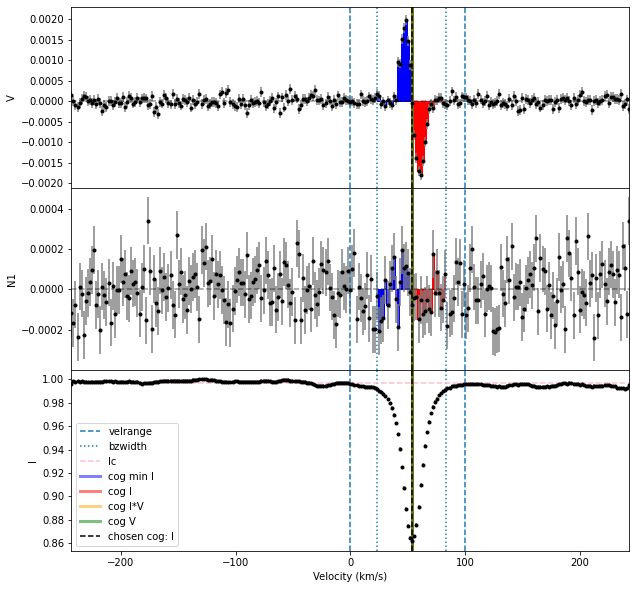

In [9]:
Bz, fig = pol.bz.calcBz(lsd, norm='auto', cog='I', 
                   velrange=[0,100],bzwidth=30, 
                   geff=1.2, lambda0=5000*u.AA,
                   plot=True, )    

# simple display of the pandas dataframe
Bz.style

The Pandas documentation has tons of information on how to manipulate dataframes, but here I just show quickly how to extract a particular value from the dataframe

In [10]:
# To extract the entry for the Bz column:
print(Bz.at[0,"V bz (G)"])

# The 0 is the index of the row (there is only one row)

94.10499747294118


## 2. How to run the Bz calculation in a loop and creating a single result table. 

We can easily loop over a list of lsd profiles, and concatenate all of the resulting Pandas datafrae rows into a single column, and add a column with the name of the stars. 

In [11]:
import copy

files = ['SampleLSD.s', 'SampleLSD2.s']


for i in range(0,2):
    # loading the LSD profile
    print('### {}'.format(files[i]))
    lsd = pol.iolsd.read_lsd('SampleData/{}'.format(files[i]))
    Bz = pol.bz.calcBz(lsd, cog='I', velrange=[0,100], plot=False,
      bzwidth=30, lambda0=5000*u.AA ) 
    if i==0:
        Bz_table=copy.copy(Bz)
    else:
        Bz_table = pd.concat([Bz_table, Bz], ignore_index = True)
        
#Let's add a column to the table with the filename
Bz_table.insert(0, "Filename", files, True)

# You can easily add a row to the table with the names of the LSD profiles. 
names = ['HD1', 'HD2']
Bz_table.insert(0, "Star", names, True)

#display the table
Bz_table.style

### SampleLSD.s
using AUTO method for the normalization
  using the median of the continuum outside of the line
0.99703
[0.99182 0.99032 0.98926 0.98774 0.98527 0.98297 0.9793  0.97547 0.9696
 0.96232 0.95282 0.94061 0.92472 0.90728 0.88962 0.87485 0.86456 0.862
 0.86598 0.87584 0.89123 0.90964 0.9271  0.94302 0.95473 0.96383 0.97089
 0.9763  0.9805  0.98326 0.98633 0.98805 0.98952 0.99111]
### SampleLSD2.s
using AUTO method for the normalization
  using the median of the continuum outside of the line
0.99529
[0.99542 0.99603 0.99516 0.99467 0.99487 0.99377 0.9922  0.98905 0.98461
 0.97635 0.96399 0.94574 0.92266 0.89672 0.87069 0.84933 0.83787 0.83737
 0.84856 0.86955 0.89659 0.92406 0.94804 0.96652 0.9786  0.98651 0.99023
 0.99262 0.99372 0.99481 0.99535 0.99489 0.99529 0.99514]


/Users/vpetit/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/vpetit/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,Star,Filename,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),N1 bz (G),N1 bz sig (G),N2 bz (G),N2 bz sig (G)
0,HD1,SampleLSD.s,0.997030,53.359239,23.359239,83.359239,94.104997,8.805572,-1.920536,8.631324,-0.000000,nan
1,HD2,SampleLSD2.s,0.995290,22.391082,-7.608918,52.391082,33.664584,22.348803,6.933104,22.348366,-0.000000,nan


You can quickly save this table as an ascii file, or cvs file, etc. (see Pandas documentation)

In [12]:
Bz_table.to_csv('BzTable.csv')

You can access individual entries in the dataframe as shown in the previous example, but you can also extract rows and columns. Here's just a few examples:

In [13]:
# Get the row for HD2 only:
HD2 = Bz_table[Bz_table["Star"]=='HD2']
HD2.style

,Star,Filename,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),N1 bz (G),N1 bz sig (G),N2 bz (G),N2 bz sig (G)
1,HD2,SampleLSD2.s,0.995290,22.391082,-7.608918,52.391082,33.664584,22.348803,6.933104,22.348366,-0.000000,nan


In [14]:
# Get the column for the Ic and cog values
Subset = Bz_table[["Ic", "cog"]]
Subset.style

,Ic,cog
0,0.997030,53.359239
1,0.995290,22.391082


In [15]:
# turn this into a numpy array
arr = Subset.to_numpy()
print(arr)

[[ 0.99703    53.35923946]
 [ 0.99529    22.39108208]]
